# Import Required Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
from pathlib import Path
from radar_exp.detect.rd_subspace_filters import ace_filter_2d, eigen_clutter_suppression, msd_per_bin_multichannel, soft_clip
from radar_exp.io.recording_adapter import RecordingAdapter
from radar_exp.dsp.rd_map import compute_range_doppler_map

# Generate Sample Range-Doppler Data

Parsing D:/DataSet/fps10/roomweg_deurningerstraat
Done!


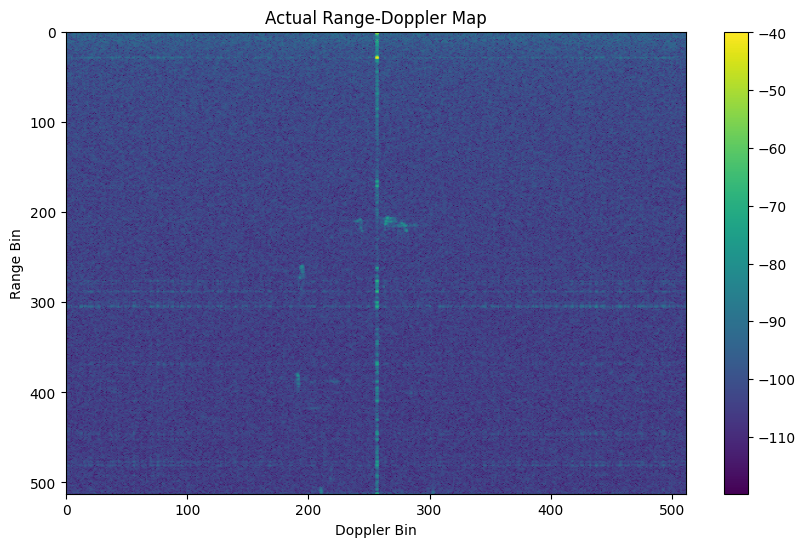

In [10]:
# ----------------------------
# Load config + recording
# ----------------------------
CONFIG_PATH = Path('config/base.yaml')
cfg = yaml.safe_load(CONFIG_PATH.read_text())
dataset_cfg = cfg.get('dataset', {})
rec = RecordingAdapter(dataset_cfg.get('path'))

dsp_cfg = cfg.get('dsp', {})

# Get a frame (e.g., frame 0)
frame_idx = 500
cube = rec.get_frame(frame_idx)

# Compute RD map and cube
rd_map, rd_cube = compute_range_doppler_map(
    cube,
    windows=dsp_cfg.get('windows', {}),
    fft_sizes=dsp_cfg.get('fft', {}),
    aggregate=dsp_cfg.get('aggregate', 'max'),
    magnitude=dsp_cfg.get('magnitude', 'db'),
)

# Visualize the RD map
plt.figure(figsize=(10, 6))
plt.imshow(rd_map, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Actual Range-Doppler Map')
plt.xlabel('Doppler Bin')
plt.ylabel('Range Bin')
plt.show()

# Apply ACE Filter

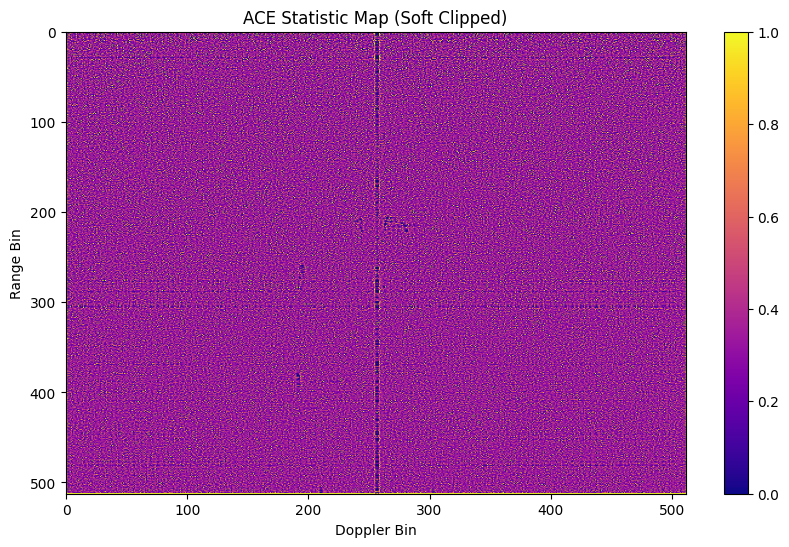

In [11]:
ace_stat = ace_filter_2d(
    rd_map,
    half_win=(6, 6),
    guard=(2, 2),
    patch=(3, 3),
    epsilon=1e-3
)

# Visualize ACE statistic
plt.figure(figsize=(10, 6))
plt.imshow(soft_clip(ace_stat), aspect='auto', cmap='plasma')
plt.colorbar()
plt.title('ACE Statistic Map (Soft Clipped)')
plt.xlabel('Doppler Bin')
plt.ylabel('Range Bin')
plt.show()

# Apply Eigen Clutter Suppression

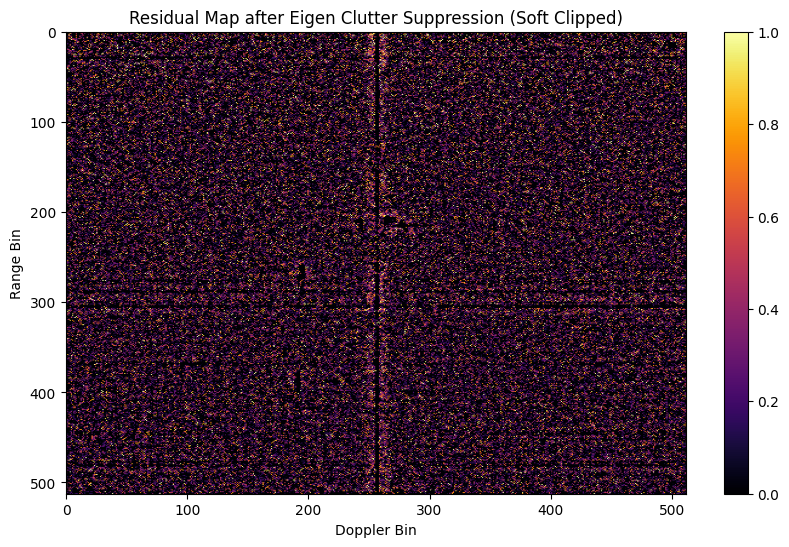

In [12]:
residual = eigen_clutter_suppression(
    rd_map,
    half_win=(8, 8),
    guard=(2, 2)
)

# Visualize residual map
plt.figure(figsize=(10, 6))
plt.imshow(soft_clip(residual), aspect='auto', cmap='inferno')
plt.colorbar()
plt.title('Residual Map after Eigen Clutter Suppression (Soft Clipped)')
plt.xlabel('Doppler Bin')
plt.ylabel('Range Bin')
plt.show()

# Generate Multi-Channel Range-Doppler Data

(512, 513)


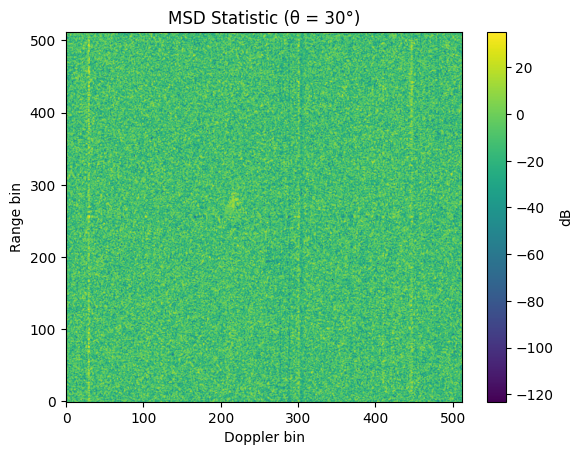

In [15]:
# rd_cube is (C, R, D) -> reorder to (R, D, C)
rd_cube_rdc = np.transpose(rd_cube, (1, 2, 0))   # (512, 513, 4)

# Number of channels
C = rd_cube.shape[0]  # 4

# Steering vector over channels (ULA with d = λ/2)
theta = np.pi / 6  # 30°
steering = np.exp(1j * 2 * np.pi * (np.arange(C)) * np.sin(theta) / 2).reshape(C, 1)
S = steering  # (C, 1)

# Run MSD (returns (R, D))
T_msd = msd_per_bin_multichannel(rd_cube_rdc, S, epsilon=1e-3)
print(T_msd.shape)  # (512, 513)

# Plot as a 2D RD map
import matplotlib.pyplot as plt
plt.imshow(20*np.log10(T_msd + 1e-12), aspect='auto', origin='lower')
plt.xlabel('Doppler bin')
plt.ylabel('Range bin')
plt.title('MSD Statistic (θ = 30°)')
plt.colorbar(label='dB')
plt.show()


# Apply MSD Filter

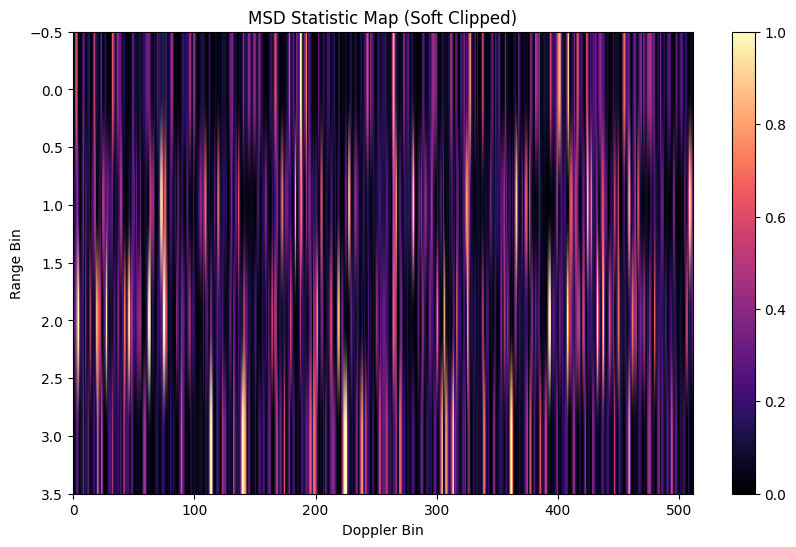

In [14]:
T_msd = msd_per_bin_multichannel(rd_cube_demo, S, epsilon=1e-3)

# Visualize MSD statistic
plt.figure(figsize=(10, 6))
plt.imshow(soft_clip(T_msd), aspect='auto', cmap='magma')
plt.colorbar()
plt.title('MSD Statistic Map (Soft Clipped)')
plt.xlabel('Doppler Bin')
plt.ylabel('Range Bin')
plt.show()